In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob
import multiprocessing
import graphviz

## Import Data

In [2]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
# print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
# print(features_columns)

In [3]:
# Selected by eliminating 10 features with lowest abs importance_coed in log regression 
features_columns =['000001.SS', '^BSESN', '^BVSP', '^FCHI', '^FTLC', '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI',
 'current_acct_lag2', 'npl_lag2', 'npl_lag1', 'Population_lag2',
       'Recession_Indicators_lag1', 'Population_lag1', 'volatility_lag1',
       'volatility_lag2', 'current_acct_lag1', 'turnover_lag1',
       'volume_change_lag2', 'Recession_Indicators_lag2', 'turnover_lag2',
       'Unemployment_lag2', '10YGov_BondYield_lag2',
       '10YGov_BondYield_lag1', 'Unemployment_lag1', 'Ted_Rate_lag1',
       'GDP_lag2', 'inflation_lag2', 'GDP_lag1',
       'Crude_Oil_Index_Excess_Return_lag2',
       'Crude_Oil_Index_Excess_Return_lag1', 'housing_lag2',
       'price_change_lag1', 'inflation_lag1']

# Build the model

In [4]:
n_cores = multiprocessing.cpu_count()

In [5]:

tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    scale_pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
    
    if not all(label == 0 for label in y_val):
        param_grid = {'max_depth':[3], 
            'n_estimators':[150,250], 
            'learning_rate':[0.02,0.1],
            'scale_pos_weight':[scale_pos_weight], 
            'subsample': [0.4,0.6], 
            'colsample_bytree': [0.4,0.6],
            'gamma': [0.5,1.0],
            'min_child_weight': [0.7,1.2],
            'reg_lambda': [1.0]}
        grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), param_grid, cv=tscv, scoring='f1', verbose=2, n_jobs=n_cores)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print(f"Best Param: {best_params}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]

    # Train the model
    model = xgb.XGBClassifier(objective='binary:logistic',
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        scale_pos_weight=best_params['scale_pos_weight'],
        gamma=best_params['gamma'],
        min_child_weight=best_params['min_child_weight'],
        reg_lambda=best_params['reg_lambda']
        # scale_pos_weight=best_params['scale_pos_weight']
    )
    model.fit(X_train_resampled, y_train_resampled)
    
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_names = list(X_train.columns)
    feature_importance = model.feature_importances_
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, sca

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.4s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=4.517241379310345, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

Best Score: 0.18333333333333332
Best Param: {'colsample_bytree': 0.4, 'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 1.2, 'n_estimators': 150, 'reg_lambda': 1.0, 'scale_pos_weight': 4.517241379310345, 'subsample': 0.4}
Grid search completed successfully.
prediction model trained
Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s



/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=6.142857142857143, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best Score: 0.0
Best Param: {'colsample_bytree': 0.4, 'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 0.7, 'n_estimators': 150, 'reg_lambda': 1.0, 'scale_pos_weight': 6.142857142857143, 'subsample': 0.4}
Grid search completed successfully.
prediction model trained
Fitting 5 folds for each of 64 candidates, totalling 320 fits


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_valid

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.

response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of [0]

  warnings.warn(
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/me

[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s


response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of [0]

  warnings.warn(
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_valid

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.02, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2

/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.ju

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/utils/_

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=0.7, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=150, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1.2, n_estimators=250, reg_lambda=1.0, scale_pos_weight=5.111111111111111, subsample=0.4; total time=   0.3s


/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/me/.julia/conda/3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/me/.julia/conda/3/lib/p

Best Score: nan
Best Param: {'colsample_bytree': 0.4, 'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 0.7, 'n_estimators': 150, 'reg_lambda': 1.0, 'scale_pos_weight': 5.111111111111111, 'subsample': 0.4}
Grid search completed successfully.
prediction model trained
prediction model trained
prediction model trained


PermutationExplainer explainer: 71it [00:13,  2.28it/s]                        


In [6]:
best_params_list

[{'colsample_bytree': 0.4,
  'gamma': 0.5,
  'learning_rate': 0.02,
  'max_depth': 3,
  'min_child_weight': 1.2,
  'n_estimators': 150,
  'reg_lambda': 1.0,
  'scale_pos_weight': 4.517241379310345,
  'subsample': 0.4},
 {'colsample_bytree': 0.4,
  'gamma': 0.5,
  'learning_rate': 0.02,
  'max_depth': 3,
  'min_child_weight': 0.7,
  'n_estimators': 150,
  'reg_lambda': 1.0,
  'scale_pos_weight': 6.142857142857143,
  'subsample': 0.4},
 {'colsample_bytree': 0.4,
  'gamma': 0.5,
  'learning_rate': 0.02,
  'max_depth': 3,
  'min_child_weight': 0.7,
  'n_estimators': 150,
  'reg_lambda': 1.0,
  'scale_pos_weight': 5.111111111111111,
  'subsample': 0.4}]

In [7]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_XGBoost_selected_features.csv", index=False)
evaluation_df

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,Unemployment_lag1_importance,Ted_Rate_lag1_importance,GDP_lag2_importance,inflation_lag2_importance,GDP_lag1_importance,Crude_Oil_Index_Excess_Return_lag2_importance,Crude_Oil_Index_Excess_Return_lag1_importance,housing_lag2_importance,price_change_lag1_importance,inflation_lag1_importance
0,1998-09-30,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[45, 23], [1, 1]]",0.041667,0.500000,0.076923,...,0.023949,0.041717,0.034745,0.019211,0.040140,0.043799,0.044328,0.044406,0.023956,0.019960
1,1998-09-30,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[31, 11], [11, 17]]",0.607143,0.607143,0.607143,...,0.019127,0.030925,0.045314,0.021107,0.035222,0.034406,0.049452,0.029972,0.040096,0.020358
2,1998-09-30,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[34, 30], [0, 6]]",0.166667,1.000000,0.285714,...,0.018790,0.034586,0.032703,0.029579,0.027871,0.032048,0.023674,0.027119,0.041285,0.012125
3,1998-09-30,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[9, 50], [3, 8]]",0.137931,0.727273,0.231884,...,0.023276,0.032337,0.025177,0.022151,0.027542,0.033355,0.029725,0.028627,0.044149,0.017698
4,1998-09-30,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[28, 41], [0, 1]]",0.023810,1.000000,0.046512,...,0.021311,0.034745,0.034928,0.015607,0.022628,0.027697,0.024756,0.033574,0.031124,0.015790


## Shap Values

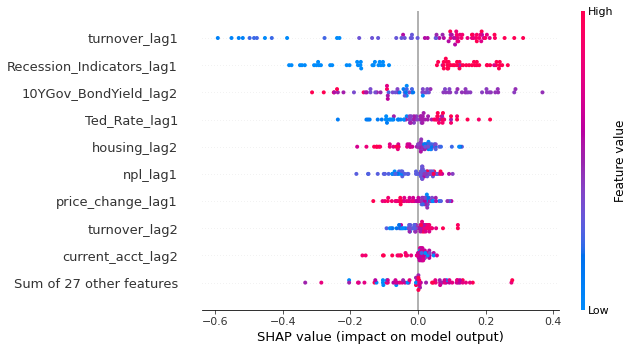

In [8]:
shap.plots.beeswarm(shap_values)

# Feature Importance

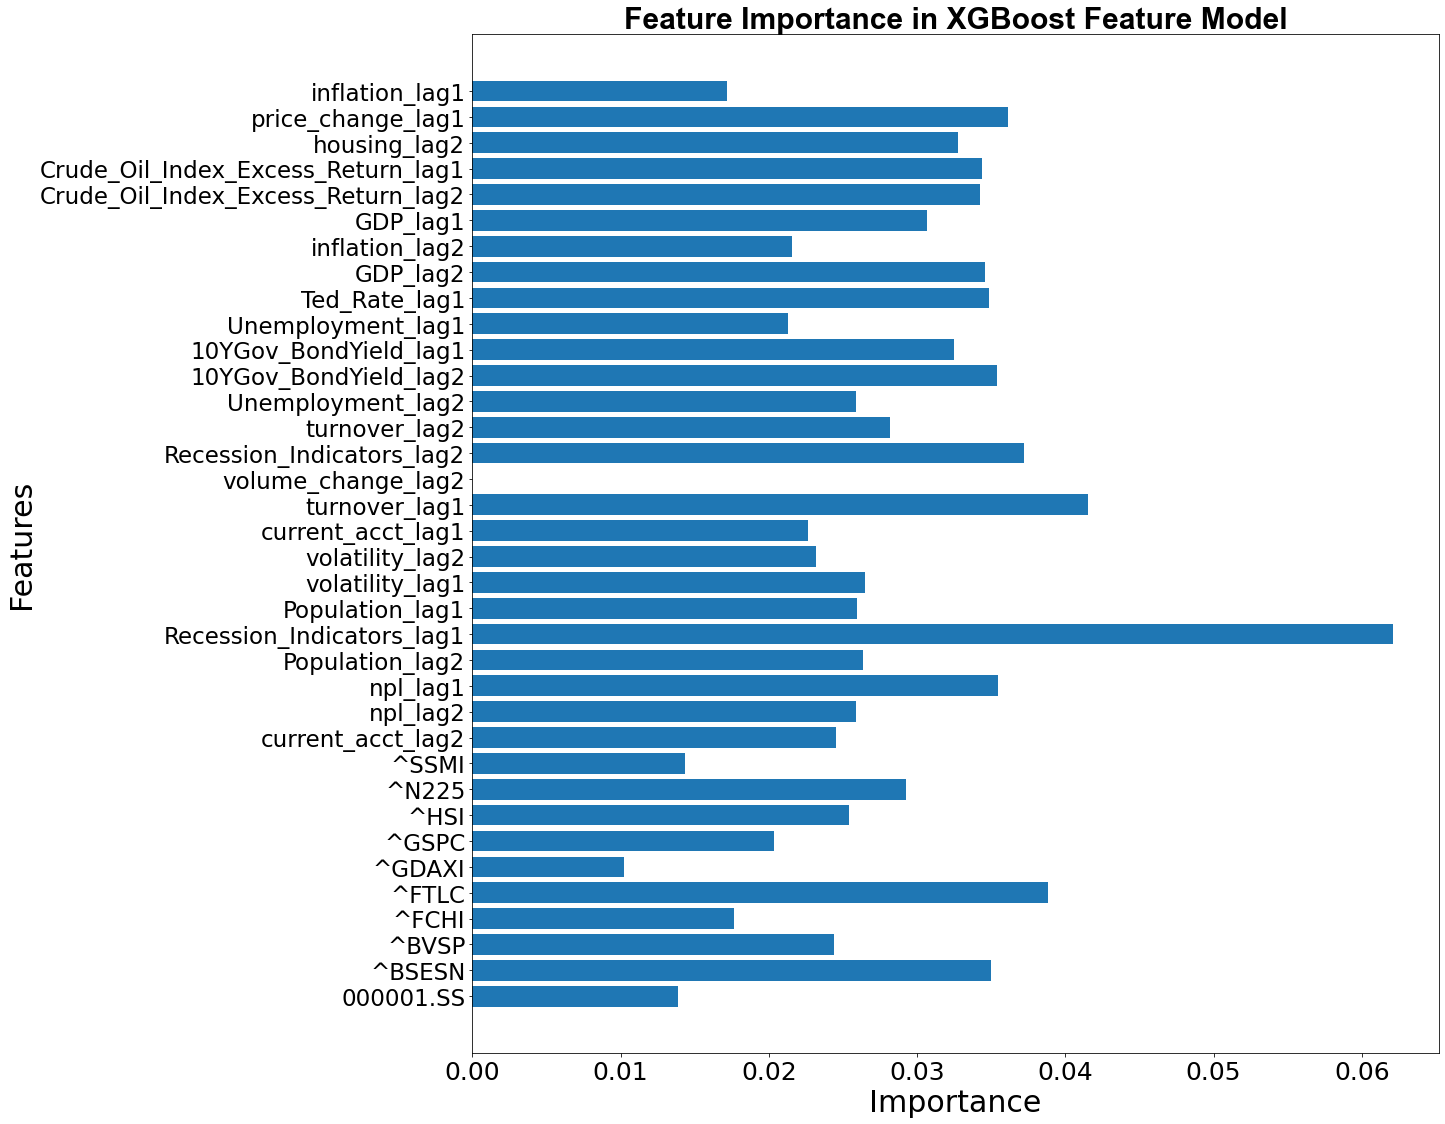

In [5]:
model_name = "XGBoost Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [10]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.5482957308333664


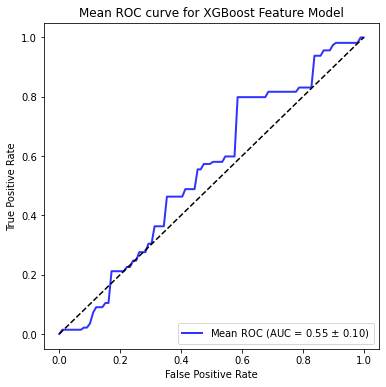

In [11]:
plot_roc_curve(evaluation_df, model_name)

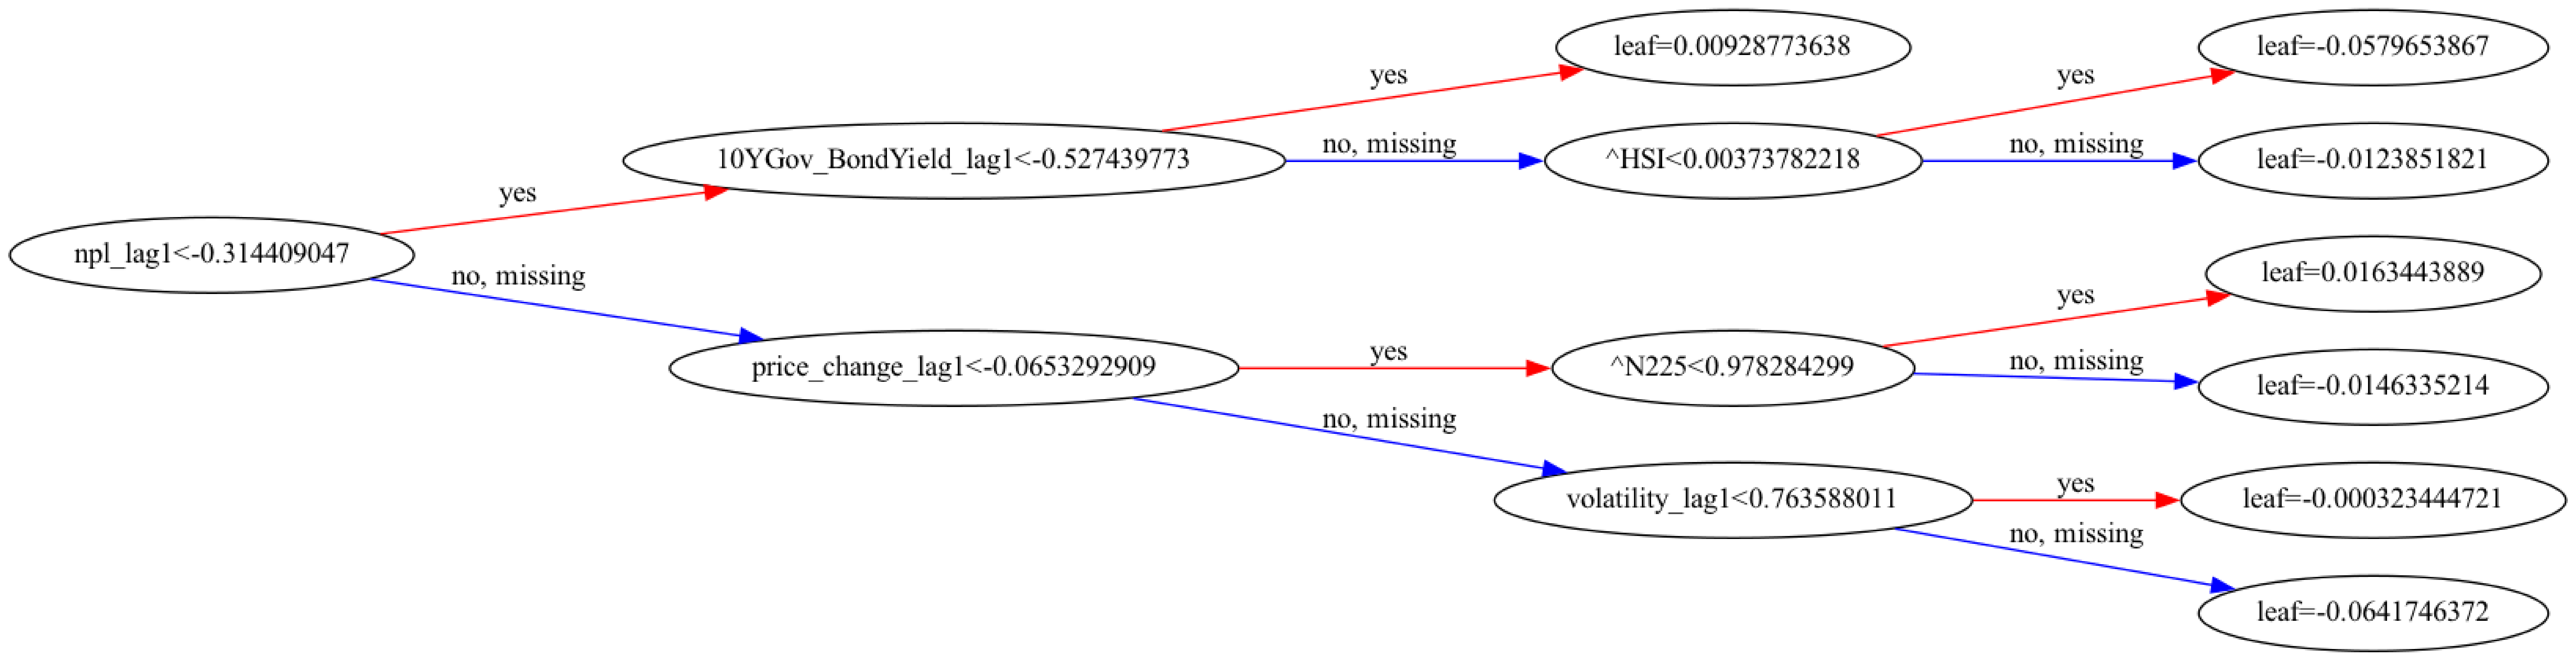

In [12]:
# pip install graphviz
fig, ax = plt.subplots(figsize=(170, 170))
xgb.plot_tree(model, ax=ax, rankdir='LR')
plt.show() 

In [13]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)